In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats.stats import pearsonr
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import util
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

In [45]:
data = pd.read_csv('../data/all_data.csv',index_col=0)

In [3]:
import config as cg

In [4]:
cg.dropcol

['artist.id',
 'artist.name',
 'artist_mbtags',
 'artist_mbtags_count',
 'song.id',
 'longitude',
 'release.name',
 'song.hotttnesss',
 'artist.id',
 'year',
 'release.id',
 'terms',
 'title',
 'location',
 'latitude',
 'country',
 'similar',
 'similar_hotness',
 'mbtag_0',
 'mbtag_1',
 'mbtag_2']

In [5]:
data.columns

Index(['Youtube_Hotness', 'artist.hotttnesss', 'artist.id', 'artist.name',
       'artist_mbtags', 'artist_mbtags_count', 'bars_confidence', 'bars_start',
       'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in',
       'familiarity', 'key', 'key_confidence', 'latitude', 'location',
       'longitude', 'loudness', 'mode', 'mode_confidence', 'release.id',
       'release.name', 'similar', 'song.hotttnesss', 'song.id',
       'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo',
       'terms', 'terms_freq', 'time_signature', 'time_signature_confidence',
       'title', 'year', 'decade', 'artist_firstname', 'artist_lastname',
       'mbtags_count', 'mbtag_0', 'mbtag_1', 'mbtag_2', 'similar_hotness',
       'term_id', 'title_neg', 'title_neu', 'title_pos', 'title_compound',
       'release.name_neg', 'release.name_neu', 'release.name_pos',
       'release.name_compound', 'y_fit_release', 'y_fit_title', 'y_fit_term',
       'release_svd_1_10', 'release_svd_2_10',

In [47]:
kept = list(set(data.columns)-set(cg.dropcol))#-set(cg.mbtag))

In [8]:
np.sort(kept)

array(['Youtube_Hotness', 'artist.hotttnesss', 'artist_firstname',
       'artist_freq', 'artist_lastname', 'bars_confidence', 'bars_start',
       'beats_confidence', 'beats_start', 'country_foreign',
       'country_unknown', 'country_us', 'decade', 'duration',
       'end_of_fade_in', 'familiarity', 'grammy_relevance', 'key',
       'key_confidence', 'loudness', 'mbtags_count', 'mode',
       'mode_confidence', 'release.name_compound', 'release.name_neg',
       'release.name_neu', 'release.name_pos', 'release_svd_10_10',
       'release_svd_1_10', 'release_svd_2_10', 'release_svd_3_10',
       'release_svd_4_10', 'release_svd_5_10', 'release_svd_6_10',
       'release_svd_7_10', 'release_svd_8_10', 'release_svd_9_10',
       'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo',
       'term_id', 'term_svd_10_10', 'term_svd_1_10', 'term_svd_2_10',
       'term_svd_3_10', 'term_svd_4_10', 'term_svd_5_10', 'term_svd_6_10',
       'term_svd_7_10', 'term_svd_8_10', 'term_sv

In [32]:
# real = []
# possible_repeat = []
# for i in kept:
#     if i[-2:]=='.1':
#         possible_repeat.append(i)
#     else:
#         real.append(i)

# repeat = []
# for i in possible_repeat:
#     if i[:-2] in real:
#         print(i)
#         repeat.append(i)

In [33]:
# drop1 = set(original.columns).intersection(set(cg.dropcol))

In [34]:
# drop2 = set(original.columns).intersection(set(cg.mbtag))

In [35]:
#mini_data = original.drop(columns = list(drop1)+list(drop2))

In [36]:
#mini_data = original[kept]
#mini_data = mini_data.dropna()

In [48]:
mini_data = data[kept]

In [53]:
mini_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 72 columns):
term_svd_5_10                10000 non-null float64
mode                         10000 non-null int64
title_svd_6_10               10000 non-null float64
tempo                        10000 non-null float64
artist_freq                  10000 non-null int64
release_svd_10_10            10000 non-null float64
end_of_fade_in               10000 non-null float64
release_svd_3_10             10000 non-null float64
title_svd_4_10               10000 non-null float64
Youtube_Hotness              10000 non-null float64
release.name_neu             10000 non-null float64
terms_freq                   10000 non-null float64
title_svd_1_10               10000 non-null float64
artist_firstname             10000 non-null int64
release_svd_1_10             10000 non-null float64
release_svd_9_10             10000 non-null float64
term_svd_6_10                10000 non-null float64
term_svd_7_10 

In [77]:
mini_data.describe()

,term_svd_5_10,mode,title_svd_6_10,tempo,artist_freq,release_svd_10_10,end_of_fade_in,release_svd_3_10,title_svd_4_10,Youtube_Hotness,...,release.name_neg,mbtags_count,grammy_relevance,y_fit_term,country_unknown,y_fit_release,beats_start,release.name_compound,title_svd_9_10,term_svd_8_10
count,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9.993000e+03,9993.000000,9993.000000,...,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000
mean,0.025509,0.690984,0.004989,122.895313,1043.695487,0.000553,0.756578,-8.175282e-03,0.002139,7.222088,...,0.048101,0.459121,0.896728,4.785039,0.429100,4.934333,0.428492,0.051410,-0.000029,0.026066
std,0.157701,0.462111,0.065868,35.208528,3540.652519,0.053293,1.859053,7.348019e-02,0.073108,5.133050,...,0.167584,0.651225,2.423766,3.914882,0.494972,8.780879,0.806474,0.243094,0.059132,0.138072
min,-0.000672,0.000000,-0.435551,0.000000,0.000000,-0.455925,0.000000,-6.153061e-01,-0.549388,-1.000000,...,0.000000,0.000000,0.000000,-13.815536,0.000000,-64.359938,-60.000000,-0.827100,-0.273988,-0.009768
25%,-0.000077,0.000000,-0.003696,96.952000,2.000000,-0.002842,0.000000,-1.510337e-02,-0.004200,3.761200,...,0.000000,0.000000,0.000000,3.259883,0.000000,2.426894,0.194640,0.000000,-0.004500,-0.002012
50%,-0.000002,1.000000,0.000000,120.153000,40.000000,0.000001,0.199000,-1.172592e-03,0.000000,8.117611,...,0.000000,0.000000,0.000000,5.569989,0.000000,6.922869,0.332560,0.000000,0.000000,-0.000015
75%,0.000053,1.000000,0.004307,144.005000,348.000000,0.004976,0.421000,4.003894e-09,0.003125,10.999246,...,0.000000,1.000000,0.000000,6.967305,1.000000,10.374039,0.500670,0.000000,0.006556,0.000493
max,0.999998,1.000000,0.543139,262.828000,36110.000000,0.573733,43.119000,6.490765e-01,0.723734,20.285925,...,1.000000,3.000000,50.000000,13.889231,1.000000,53.233179,12.245830,0.958400,0.492881,0.950160


In [54]:
mini_data = mini_data.dropna()
X = mini_data.drop(columns=['Youtube_Hotness'])
y = mini_data['Youtube_Hotness']

In [55]:
year = pd.get_dummies(X['decade'])
year.columns=['year_'+str(i) for i in year.columns]

In [170]:
year.shape

(9993, 11)

In [56]:
X = pd.concat([X,year.drop('year_0',axis=1)],axis = 1)
X = X.drop(columns = ['decade'])

In [97]:
X1=X.drop(columns=['y_fit_term','y_fit_title','y_fit_release'])

In [98]:
X1.shape

(9993, 77)

In [57]:
X.shape

(9993, 80)

In [171]:
X.columns

Index(['term_svd_5_10', 'mode', 'title_svd_6_10', 'tempo', 'artist_freq',
       'release_svd_10_10', 'end_of_fade_in', 'release_svd_3_10',
       'title_svd_4_10', 'release.name_neu', 'terms_freq', 'title_svd_1_10',
       'artist_firstname', 'release_svd_1_10', 'release_svd_9_10',
       'term_svd_6_10', 'term_svd_7_10', 'term_svd_2_10', 'country_foreign',
       'term_svd_4_10', 'y_fit_title', 'release_svd_7_10', 'key', 'term_id',
       'release_svd_5_10', 'title_neg', 'mode_confidence', 'key_confidence',
       'artist.hotttnesss', 'release_svd_6_10', 'tatums_start',
       'title_svd_10_10', 'title_svd_8_10', 'release.name_pos',
       'beats_confidence', 'title_compound', 'term_svd_1_10', 'title_svd_3_10',
       'release_svd_8_10', 'release_svd_4_10', 'loudness', 'start_of_fade_out',
       'bars_confidence', 'time_signature_confidence', 'artist_lastname',
       'term_svd_10_10', 'title_neu', 'duration', 'term_svd_3_10',
       'term_svd_9_10', 'title_pos', 'familiarity', 'bar

In [58]:
# terms = pd.get_dummies(X['term_id'])

In [59]:
# colname=[]
# for i in terms.columns:
#     colname.append('term'+str(i))

In [60]:
# terms.columns = colname
# X = pd.concat([X,terms],axis = 1)
# X = X.drop(columns = ['term_id'])

In [61]:
# country = pd.get_dummies(X['country'])
# colname = []
# for i in country.columns:
#     colname.append('country'+str(i))
# country.columns = colname
# X = pd.concat([X,country],axis = 1)
# X = X.drop(columns = ['country'])

### Feature Extraction

In [109]:
def minmax_scalar(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 2019)
    scaler = MinMaxScaler()
    scaler.partial_fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train),columns =X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test),columns =X_test.columns)
    return X_train,X_test,y_train,y_test

In [110]:
X_train1,X_test1,y_train1,y_test1 = minmax_scalar(X1,y)
X_train,X_test,y_train,y_test = minmax_scalar(X,y)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  after removing the cwd from sys.path.


In [128]:
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display, Math,Latex

In [180]:
def matric(clf,X_train,X_test,y_train,y_test,title='ridge'):
    y_pred_train=clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    mse=mean_squared_error(y_train,y_pred_train)
    mse_test=mean_squared_error(y_test,y_pred_test)
    r2=r2_score(y_train,y_pred_train)
    r2_test=r2_score(y_test,y_pred_test)
    display(Latex('--'*5+title+'--'*5))
    display(Latex(r'    Training MSE: {:.2f}'.format(mse)))
    display(Latex(r'    Training $R^2$: {:.2%}'.format(r2)))
    display(Latex(r'    Test MSE of: {:.2f}'.format(mse_test)))
    display(Latex(r'    Test $R^2$: {:.2%}'.format(r2_test)))
    return mse,r2,mse_test,r2_test

linear regression

In [181]:

from sklearn.linear_model import LinearRegression
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [182]:
_=matric(linearModel,X_train,X_test,y_train,y_test,title=r'Linear Regression | with y_fit')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [183]:
linearModel1 = LinearRegression()
linearModel1.fit(X_train1, y_train)
_=matric(linearModel1,X_train1,X_test1,y_train,y_test,title=r'Linear Regression | without y_fit')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

ridge regression

In [187]:
clf = Lasso(alpha=0.01)#best_lasso.best_params_['alpha'])
clf.fit(X_train,y_train)
_=matric(clf,X_train,X_test,y_train,y_test,title=r'ridge $\alpha=0.01$ | with y_fit')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [192]:
X1.columns[abs(clf1.coef_)>0]

Index(['term_svd_5_10', 'mode', 'tempo', 'artist_freq', 'release.name_neu',
       'title_svd_1_10', 'release_svd_1_10', 'term_svd_6_10', 'term_svd_2_10',
       'term_id', 'artist.hotttnesss', 'beats_confidence', 'term_svd_1_10',
       'release_svd_4_10', 'loudness', 'start_of_fade_out',
       'time_signature_confidence', 'term_svd_10_10', 'title_neu',
       'term_svd_9_10', 'familiarity', 'country_us', 'title_svd_2_10',
       'time_signature', 'country_unknown', 'release.name_compound',
       'year_1960', 'year_1970', 'year_1980', 'year_1990', 'year_2000'],
      dtype='object')

In [193]:
clf1 = Lasso(alpha=0.01)#best_lasso.best_params_['alpha'])
clf1.fit(X_train1,y_train1)
_=matric(clf1,X_train1,X_test1,y_train1,y_test1,title=r'ridge $\alpha=0.01$ | without y_fit')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [82]:
from sklearn.model_selection import GridSearchCV

In [111]:
# params = {'alpha':np.linspace(0.5,10,50)}

# best_lasso = GridSearchCV(lasso,params,cv=3)

In [161]:
# best_lasso.fit(X_train1,y_train1)

In [113]:
# best_lasso.best_params_

{'alpha': 0.5}

In [93]:
# clf = Lasso(alpha=0.01)#best_lasso.best_params_['alpha'])
# clf.fit(X_train,y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [94]:
X.columns[abs(clf.coef_)>0]

Index(['term_svd_5_10', 'mode', 'tempo', 'artist_freq', 'release.name_neu',
       'title_svd_1_10', 'country_foreign', 'y_fit_title', 'artist.hotttnesss',
       'beats_confidence', 'loudness', 'time_signature_confidence',
       'title_neu', 'familiarity', 'time_signature', 'mbtags_count',
       'y_fit_term', 'country_unknown', 'y_fit_release', 'year_1960',
       'year_1970', 'year_1980', 'year_1990', 'year_2000'],
      dtype='object')

In [227]:
import seaborn as sns

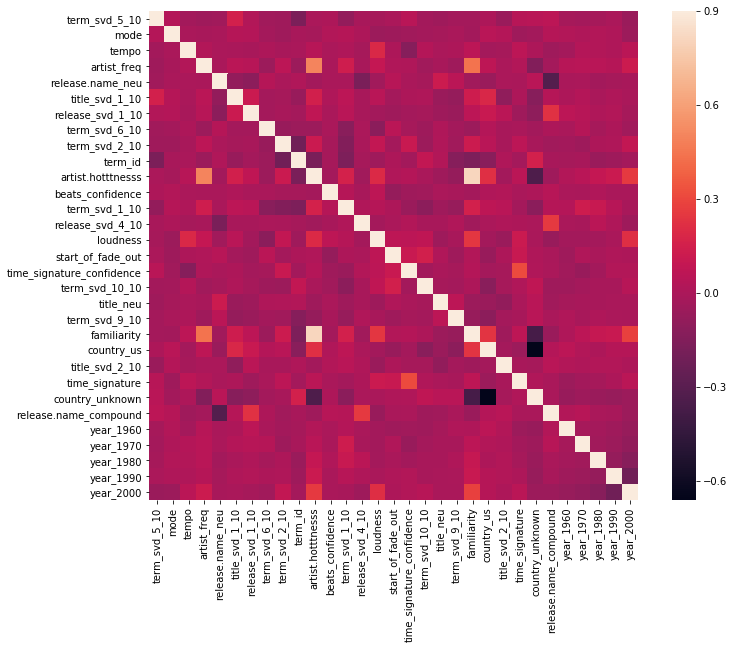

In [228]:
corrmat = X_train1.iloc[:,abs(clf1.coef_)>0].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [ ]:
clf

In [66]:
mean_squared_error(clf.predict(X_train),y_train)

24.761266700547793

In [57]:
mean_squared_error(clf.predict(X_test),y_test)

24.170898802890665

In [67]:
r2_score(clf.predict(X_train),y_train)

-50.47547377832672

In [194]:
from sklearn.ensemble import RandomForestRegressor

In [195]:
params = {'max_depth':[3,5,10,15,20],
         'n_estimators':[10,50,100]}
forest = RandomForestRegressor(random_state=0)
best_forest = GridSearchCV(forest,params,cv=3)

[3,5,8]
[10,30,50]

In [196]:
best_forest.fit(X_train1,y_train1)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 5, 10, 15, 20], 'n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [199]:
best_forest.best_params_

{'max_depth': 20, 'n_estimators': 100}

In [201]:
# clf_RF = RandomForestRegressor(best_forest.best_params_)
# clf_RF.fit(X_train1,y_train1)
_=matric(best_forest,X_train1,X_test1,y_train1,y_test1,title=r'Random Forest  | without y_fit')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [71]:
mean_squared_error(best_forest.predict(X_train),y_train)

9.79357177703936

In [72]:
best_forest.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [73]:
mean_squared_error(best_forest.predict(X_test),y_test)

17.037016925480593

In [203]:
rank_df = pd.DataFrame({'importance':best_forest.best_estimator_.feature_importances_,
              'feature':X_train1.columns}).sort_values(by='importance',
                                                      ascending=False)

In [204]:
accu_importance = [np.sum(rank_df['importance'][:i]) for i in range(1,len(rank_df)+1)]

In [205]:
rank_df['accumulated importance'] = accu_importance 


In [214]:
rank_df.sort_values(['importance'],ascending=False)

,importance,feature,accumulated importance
4,2.522307e-01,artist_freq,0.252231
27,7.157187e-02,artist.hotttnesss,0.323803
50,4.916644e-02,familiarity,0.372969
39,3.937082e-02,loudness,0.412340
46,1.632899e-02,duration,0.428669
3,1.631280e-02,tempo,0.444982
40,1.621576e-02,start_of_fade_out,0.461197
20,1.507536e-02,release_svd_7_10,0.476273
29,1.474236e-02,tatums_start,0.491015
41,1.455198e-02,bars_confidence,0.505567


In [207]:
selected = rank_df.head(30)['feature']

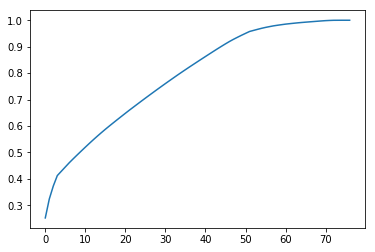

In [208]:
plt.plot(rank_df['accumulated importance'].values)

In [80]:
r2_score(best_forest.predict(X_train),y_train)

0.09314999834603288

In [81]:
r2_score(best_forest.predict(X_test),y_test)

-0.8761543865485526

In [82]:
best_forest.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [151]:
clf = RandomForestRegressor(n_estimators=100, max_depth=10,
                         random_state=0)
clf.fit(X_train[selected], y_train) 
print(r2_score(clf.predict(X_train[selected]),y_train))
print(r2_score(clf.predict(X_test[selected]),y_test))

0.16977245027224575
-0.9377115393936057


Index(['y_fit_release', 'y_fit_term', 'duration', 'loudness', 'artist_freq',
       'artist_firstname', 'y_fit_title', 'start_of_fade_out', 'tempo'],
      dtype='object')

In [216]:
try:
    import xgboost as xgb
except:
    !pip install xgboost
    import xgboost as xgb

In [85]:
# params = {'learning_rate':[0.01,0.1],
#          'colsample_bytree':[0.5,0.9],
#          'max_depth':[5,10],
#          'n_estimators':[50,100,200,500]}
# clf=xgb.XGBRegressor(objective ='reg:linear',
#                  n_jobs = 2,gpu_id=0,
#                  tree_method='gpu_hist')
# best_boost = GridSearchCV(clf,params,cv=2)

In [86]:
#best_boost.fit(X_train[selected],y_train)

In [217]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.7, 
                          learning_rate = 0.01,
                max_depth = 10, alpha = 0, 
                          n_estimators = 200,
                          tree_method='gpu_hist',
                         n_jobs = 2,gpu_id=0)

In [218]:
xg_reg.fit(X_train1,y_train1)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBoostError: b'[15:01:18] C:/Users/Administrator/Desktop/xgboost/src/tree/updater_gpu_hist.cu:980: Exception in gpu_hist: [15:01:18] c:\\users\\administrator\\desktop\\xgboost\\src\\common\\device_helpers.cuh:916: Check failed: device_ordinals.size() == 1 (0 vs. 1) XGBoost must be compiled with NCCL to use more than one GPU.\n'

In [134]:
mean_squared_error(xg_reg.predict(X_train),y_train)

8.618728526025434

In [135]:
mean_squared_error(xg_reg.predict(X_test),y_test)

18.13456874660353

In [137]:
r2_score(xg_reg.predict(X_test),y_test)

-1.840431340159716

In [139]:
r2_score(xg_reg.predict(X_train),y_train)

0.07633228803439662